# Overview
### **<center>Кейс 4. Классификация с использованием набора данных об академических успехах.</center>**

*Состав:*
- Музафаров Карим
- Цуркан Владислав
- Зенченко Илья
- Лямцев Иван
- Скиф Даниель
- Богдан

## Краткий обзор набора данных:
Цель: Набор данных был создан в рамках проекта, направленного на сокращение отсева и неуспеваемости в высших учебных заведениях.  

<br>
Признаки в наборе:  

- Perosonal Information: Marital status, gender, age at enrollment, nationality, international status, displaces status
- Family Background: Mother's and father's qualification and occupation
- Application and Admission: Application mode, application order, course, admission grade
- Academic Background: Previous qualification, previous qualification grade
- Academic Performance: Curricular units in the 1st and 2nd semesters(credited, enrolled, evaluations, approved, grades, without evaluations)
- Attendance and Financial Status: Daytime/evening attendance, educational special needs, debtor status, tuition fees up to data, scholarship holder
- Economic Indicators: Unemployment rate, inflation rate, GDP  
<br>
<br>  

- Личная информация: Семейное положение, пол, возраст при поступлении, гражданство, статус иностранного студента, статус перемещенного лица
- Семейное происхождение: Образование и профессия матери и отца
- Подача заявления и зачисление: Способ подачи заявления, очередность заявления, курс, вступительный балл
- Академическая история: Предыдущее образование, оценка предыдущего образования
- Академическая успеваемость: Учебные единицы в 1-м и 2-м семестрах (зачтенные, зачисленные, оценки, утвержденные, баллы, без оценок)
- Посещаемость и финансовое положение: Посещение дневных/вечерних занятий, особые образовательные потребности, статус должника, своевременная оплата обучения, стипендиат
- Экономические показатели: Уровень безработицы, уровень инфляции, ВВП   
<br>  

*Над набором данных была проведена предварительная обработка данных для устранения аномалий, необъяснимых выбросов и пропущенных значений. Набор не содержит дубликатов.*

# Import libraries

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

import phik
from phik.report import plot_correlation_matrix

# Import data

In [3]:
train = pd.read_csv("../data/train.csv", index_col="id")
test = pd.read_csv("../data/test.csv", index_col="id")

# EDA

## Общая информация по датасету

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

## Выделим признаки по типу данных

In [25]:
target = "Target"
features = test.columns.to_list()

categorical_features = train.select_dtypes(include=int).columns.to_list()
continuous_features = train.select_dtypes(include=float).columns.to_list()

binary_features = [col for col in categorical_features 
                   if train[col].nunique() == 2 and col != target]

discrete_features = [col for col in categorical_features 
                     if col.startswith("Curricular")] + ["Age at enrollment"]

multi_category_features = [col for col in categorical_features 
                          if col not in binary_features and col not in discrete_features and col != target]

categorical_features = list(np.setdiff1d(categorical_features, discrete_features))


In [ ]:
print(f"Числовые признаки: {continuous_features}")
print(f"Дискретные числовые признаки: {discrete_features}")
print(f"Бинарные признаки: {binary_features}")
print(f"Категориальные признаки: {multi_category_features}")

Непрерывные признаки: ['Previous qualification (grade)', 'Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 'Unemployment rate', 'Inflation rate', 'GDP']
Дискретные числовые признаки: ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)', 'Age at enrollment']
Бинарные признаки: ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']
Категориальные признаки: ['Marital status', 'Application mode', 'Application order', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualificatio

## Проверка на пропуски и дубликаты

In [7]:
train.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [8]:
train.duplicated().sum()

np.int64(0)

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000
Father's qualification,76518.0,23.425076,14.921164,1.00,4.000000,19.000000,37.000000,44.000


Пропусков и дубликатов нет

## Распределение признаков

### Распределение категориальных признаков

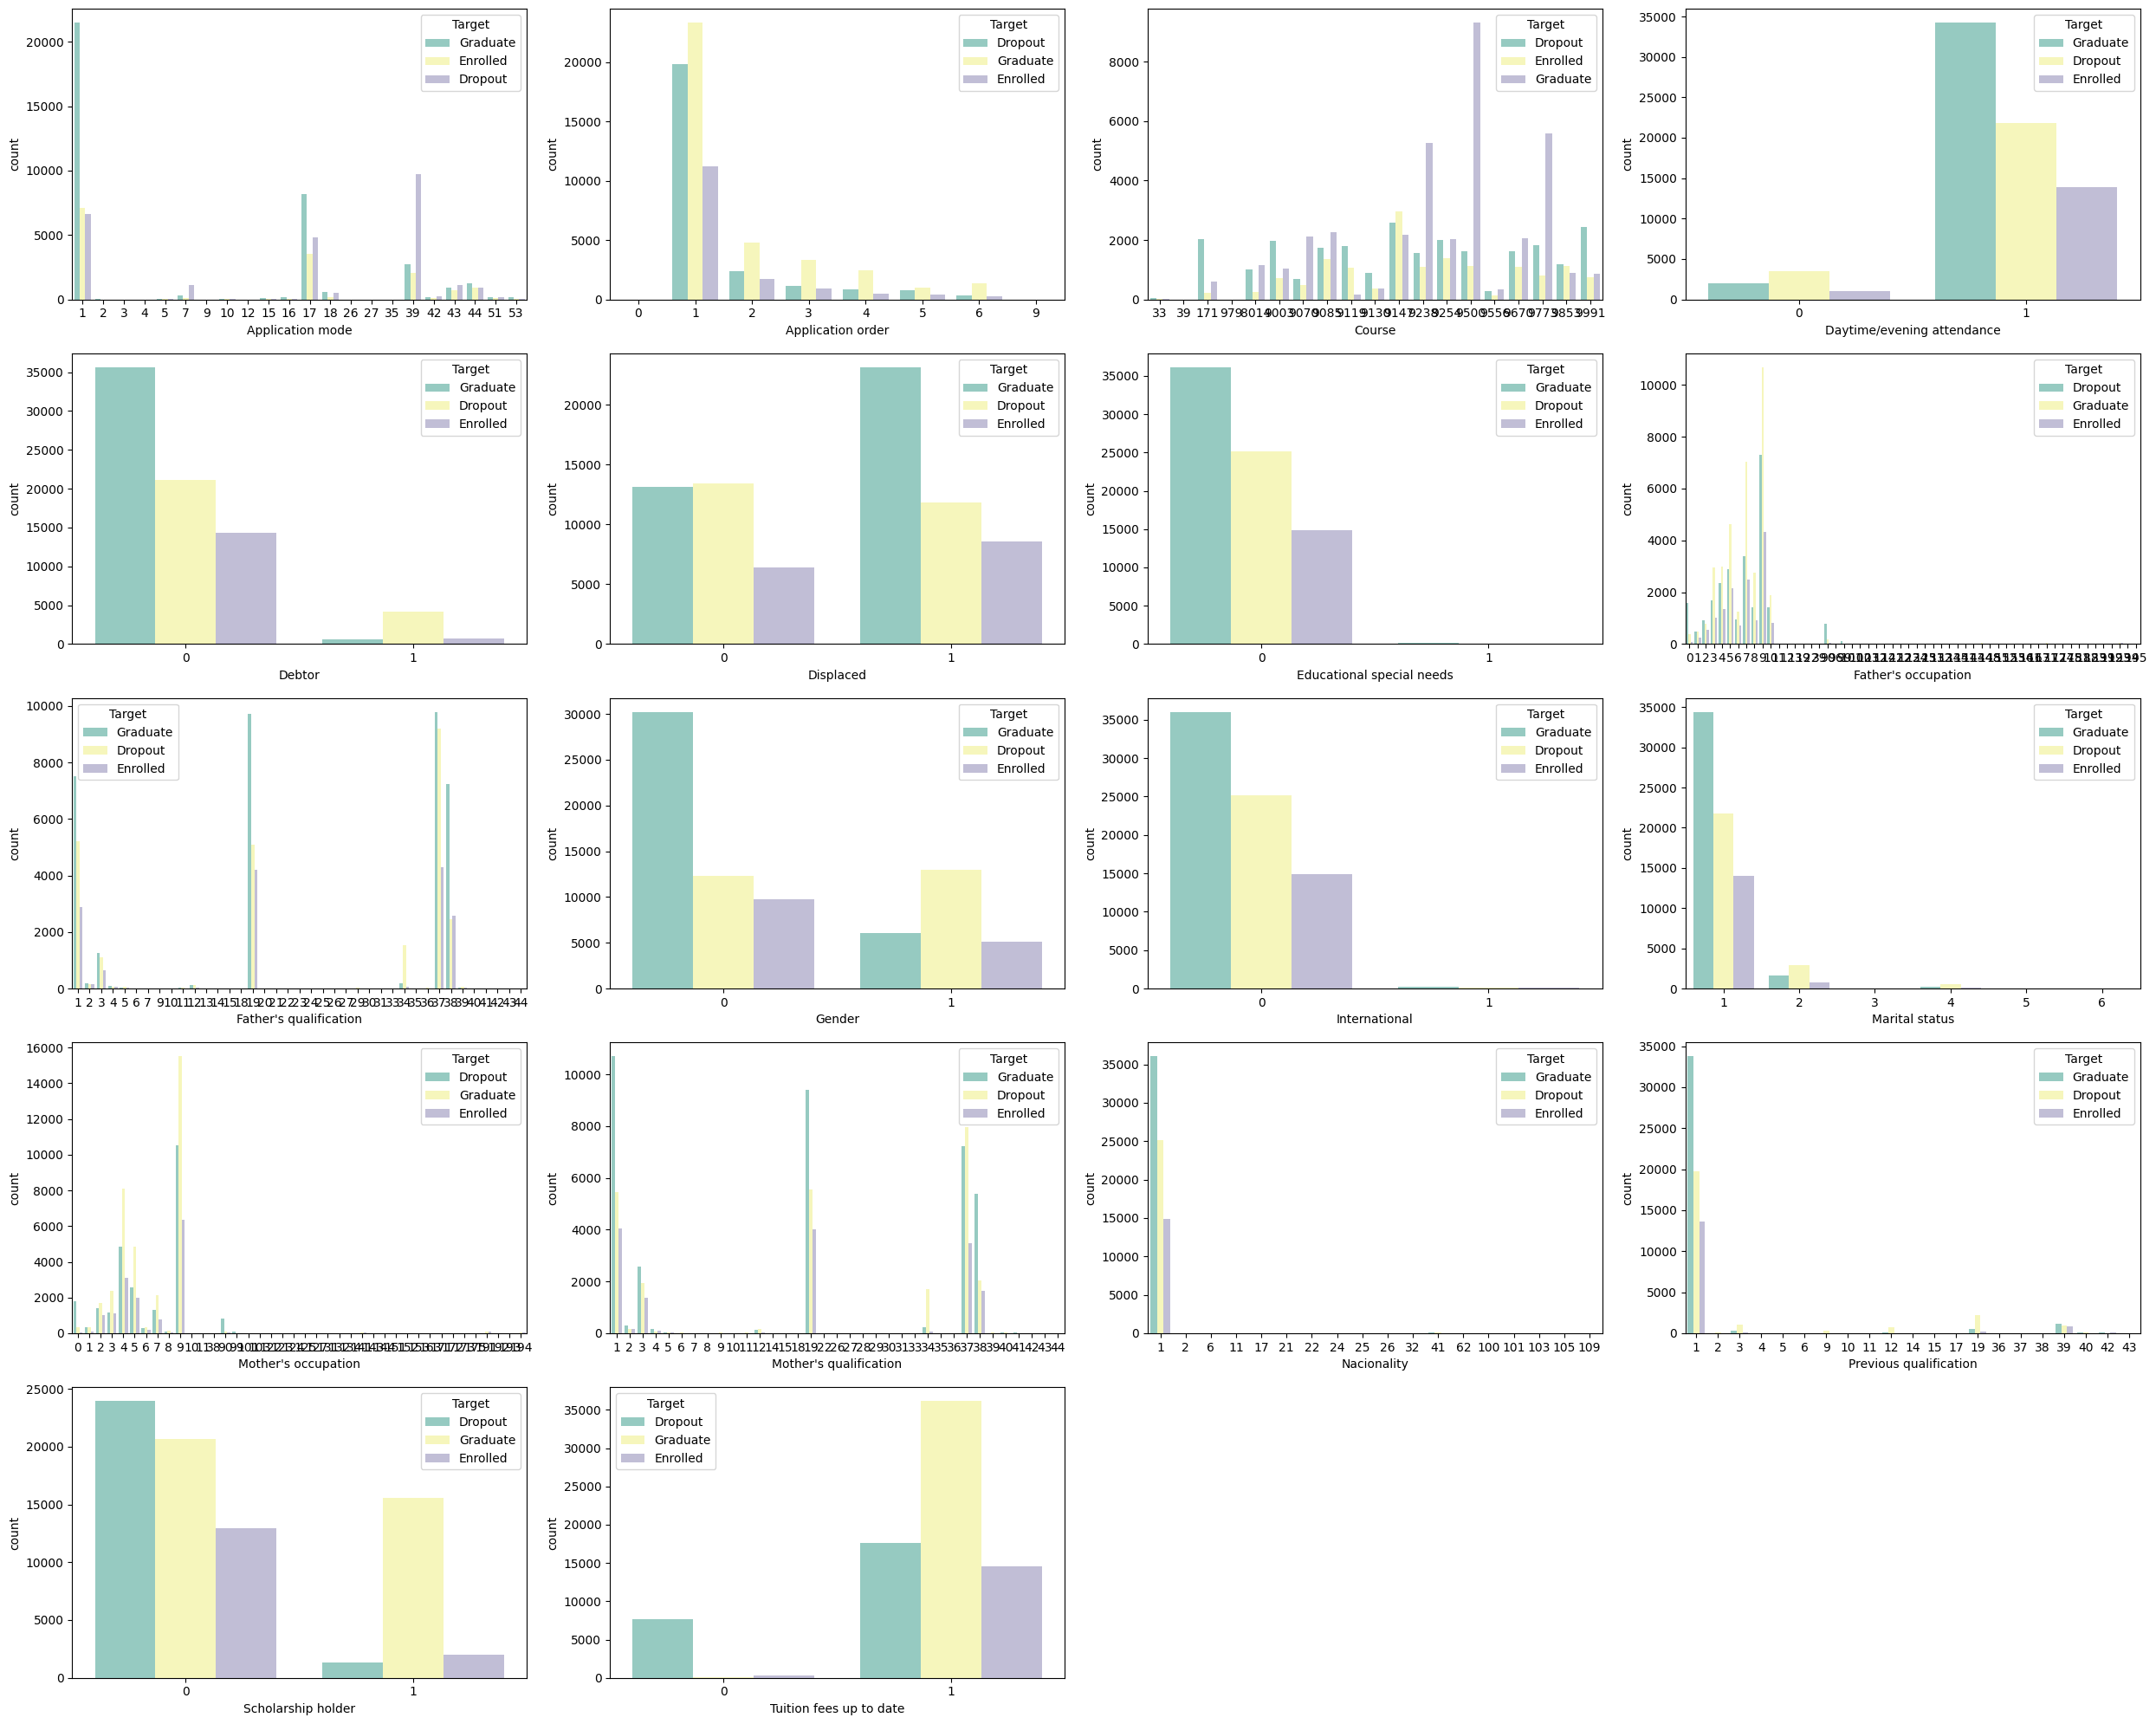

In [10]:
plt.figure(figsize=(25, 20))
for i, col in enumerate(categorical_features):
    plt.subplot(5, 4, i+1)
    sns.countplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

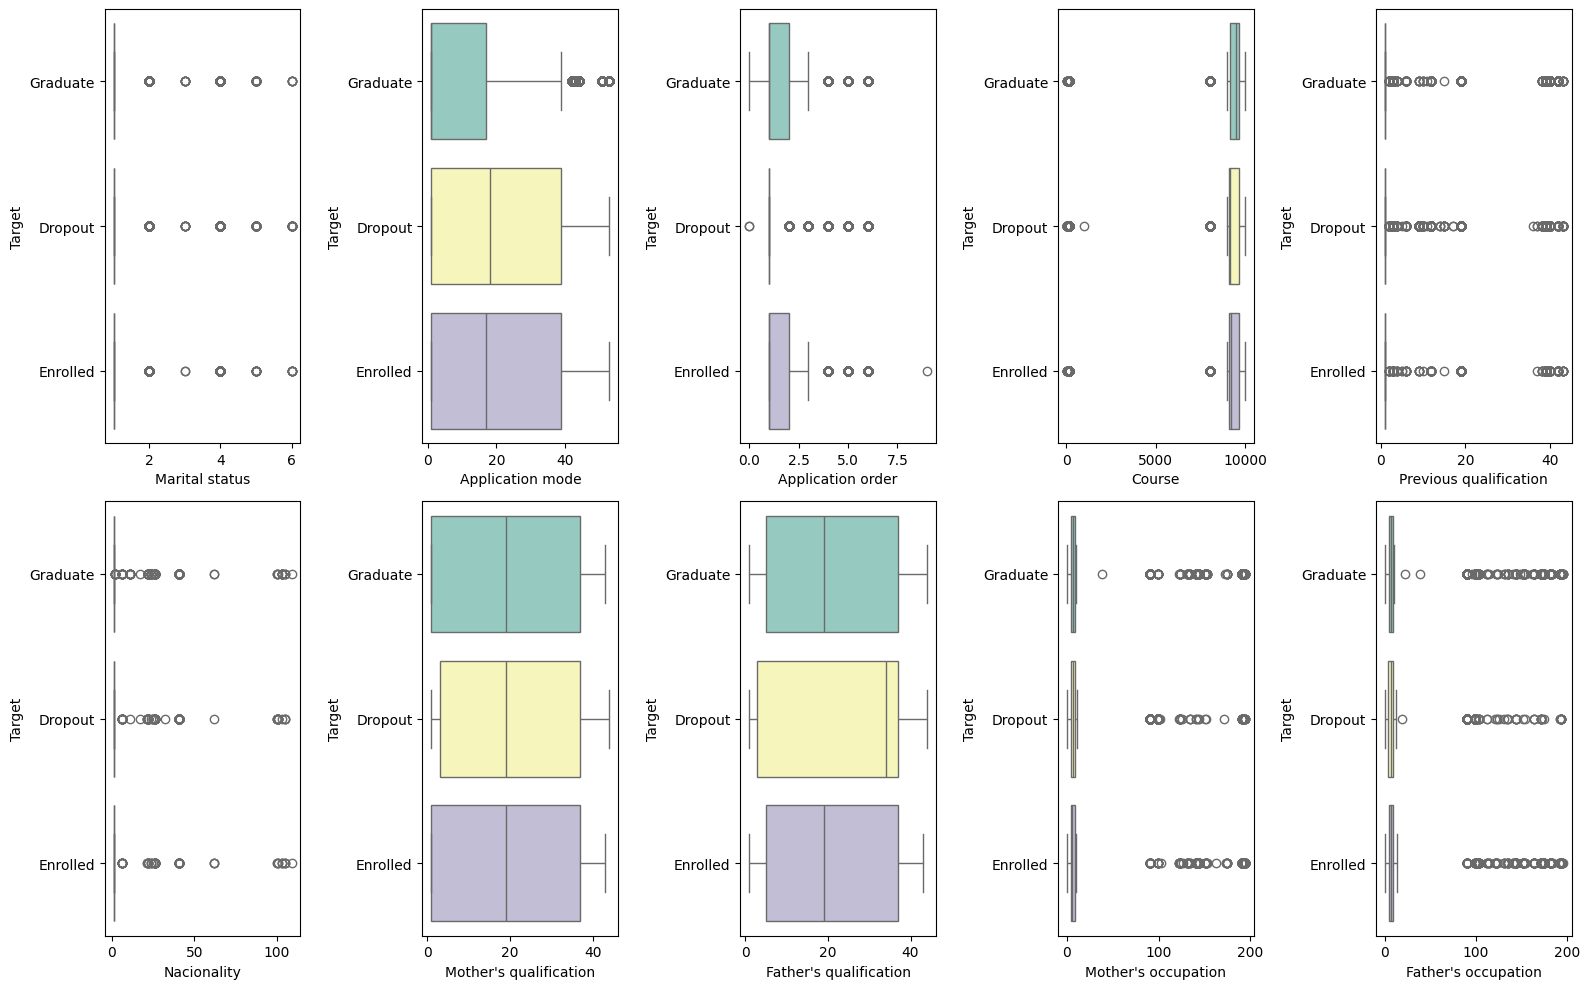

In [11]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(multi_category_features):
    plt.subplot(2, 5, i+1)
    sns.boxplot(data=train, x=col, y=target, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

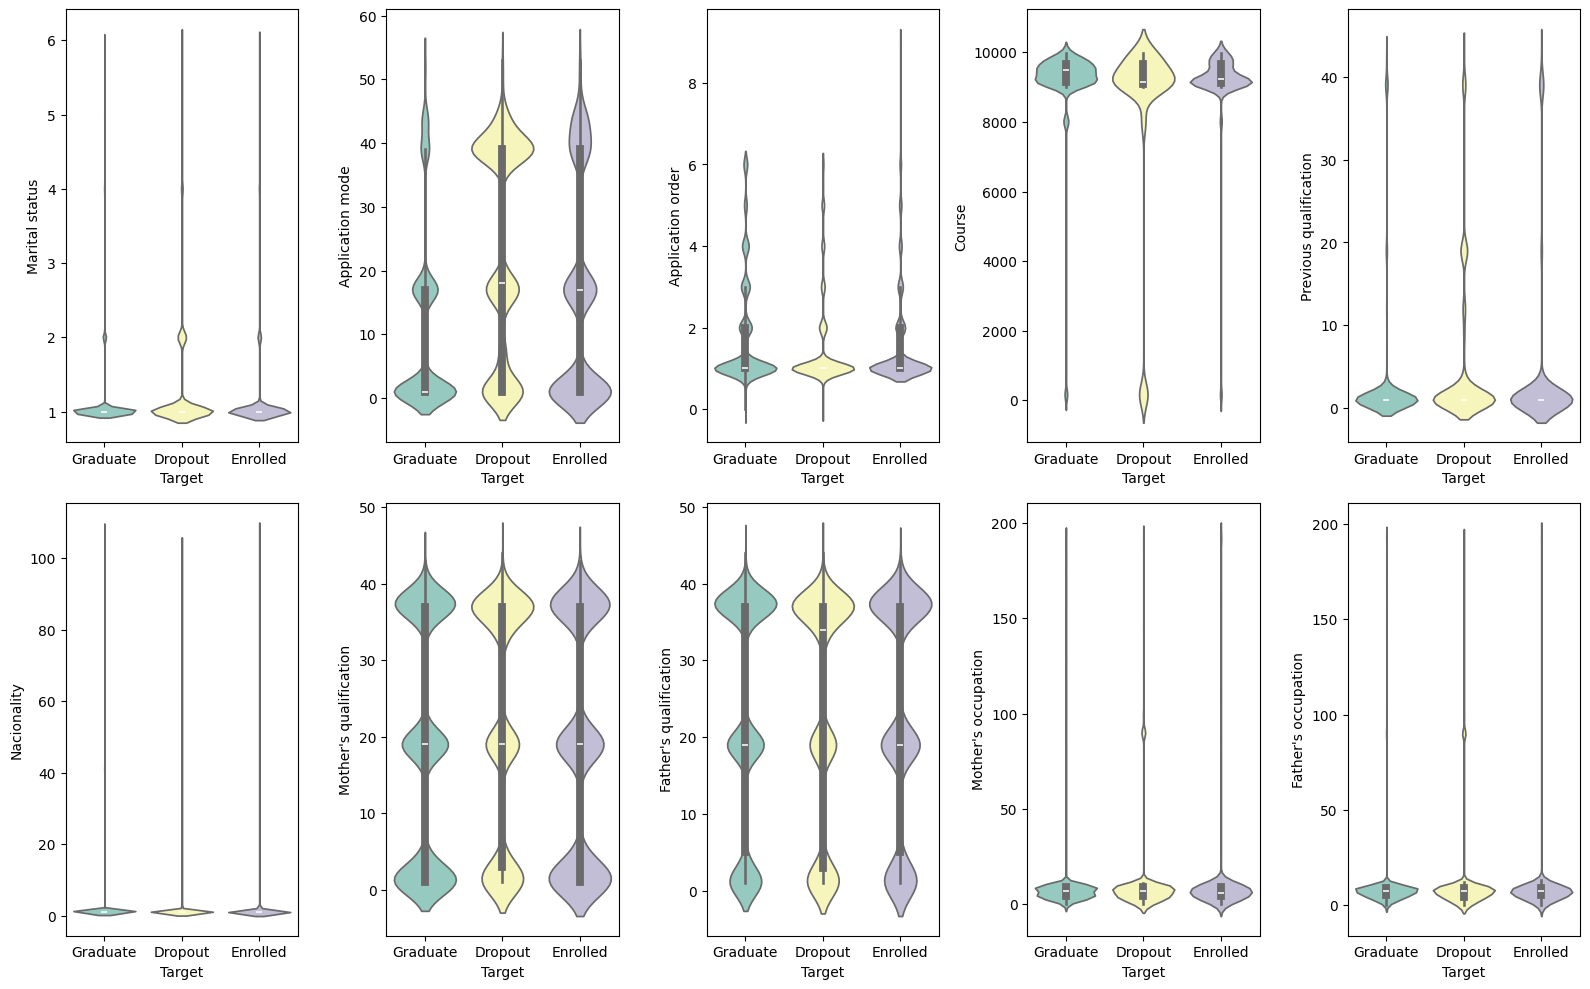

In [12]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(multi_category_features):
    plt.subplot(2, 5, i+1)
    sns.violinplot(data=train, x=target, y=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

### Распределение дискретных признаков

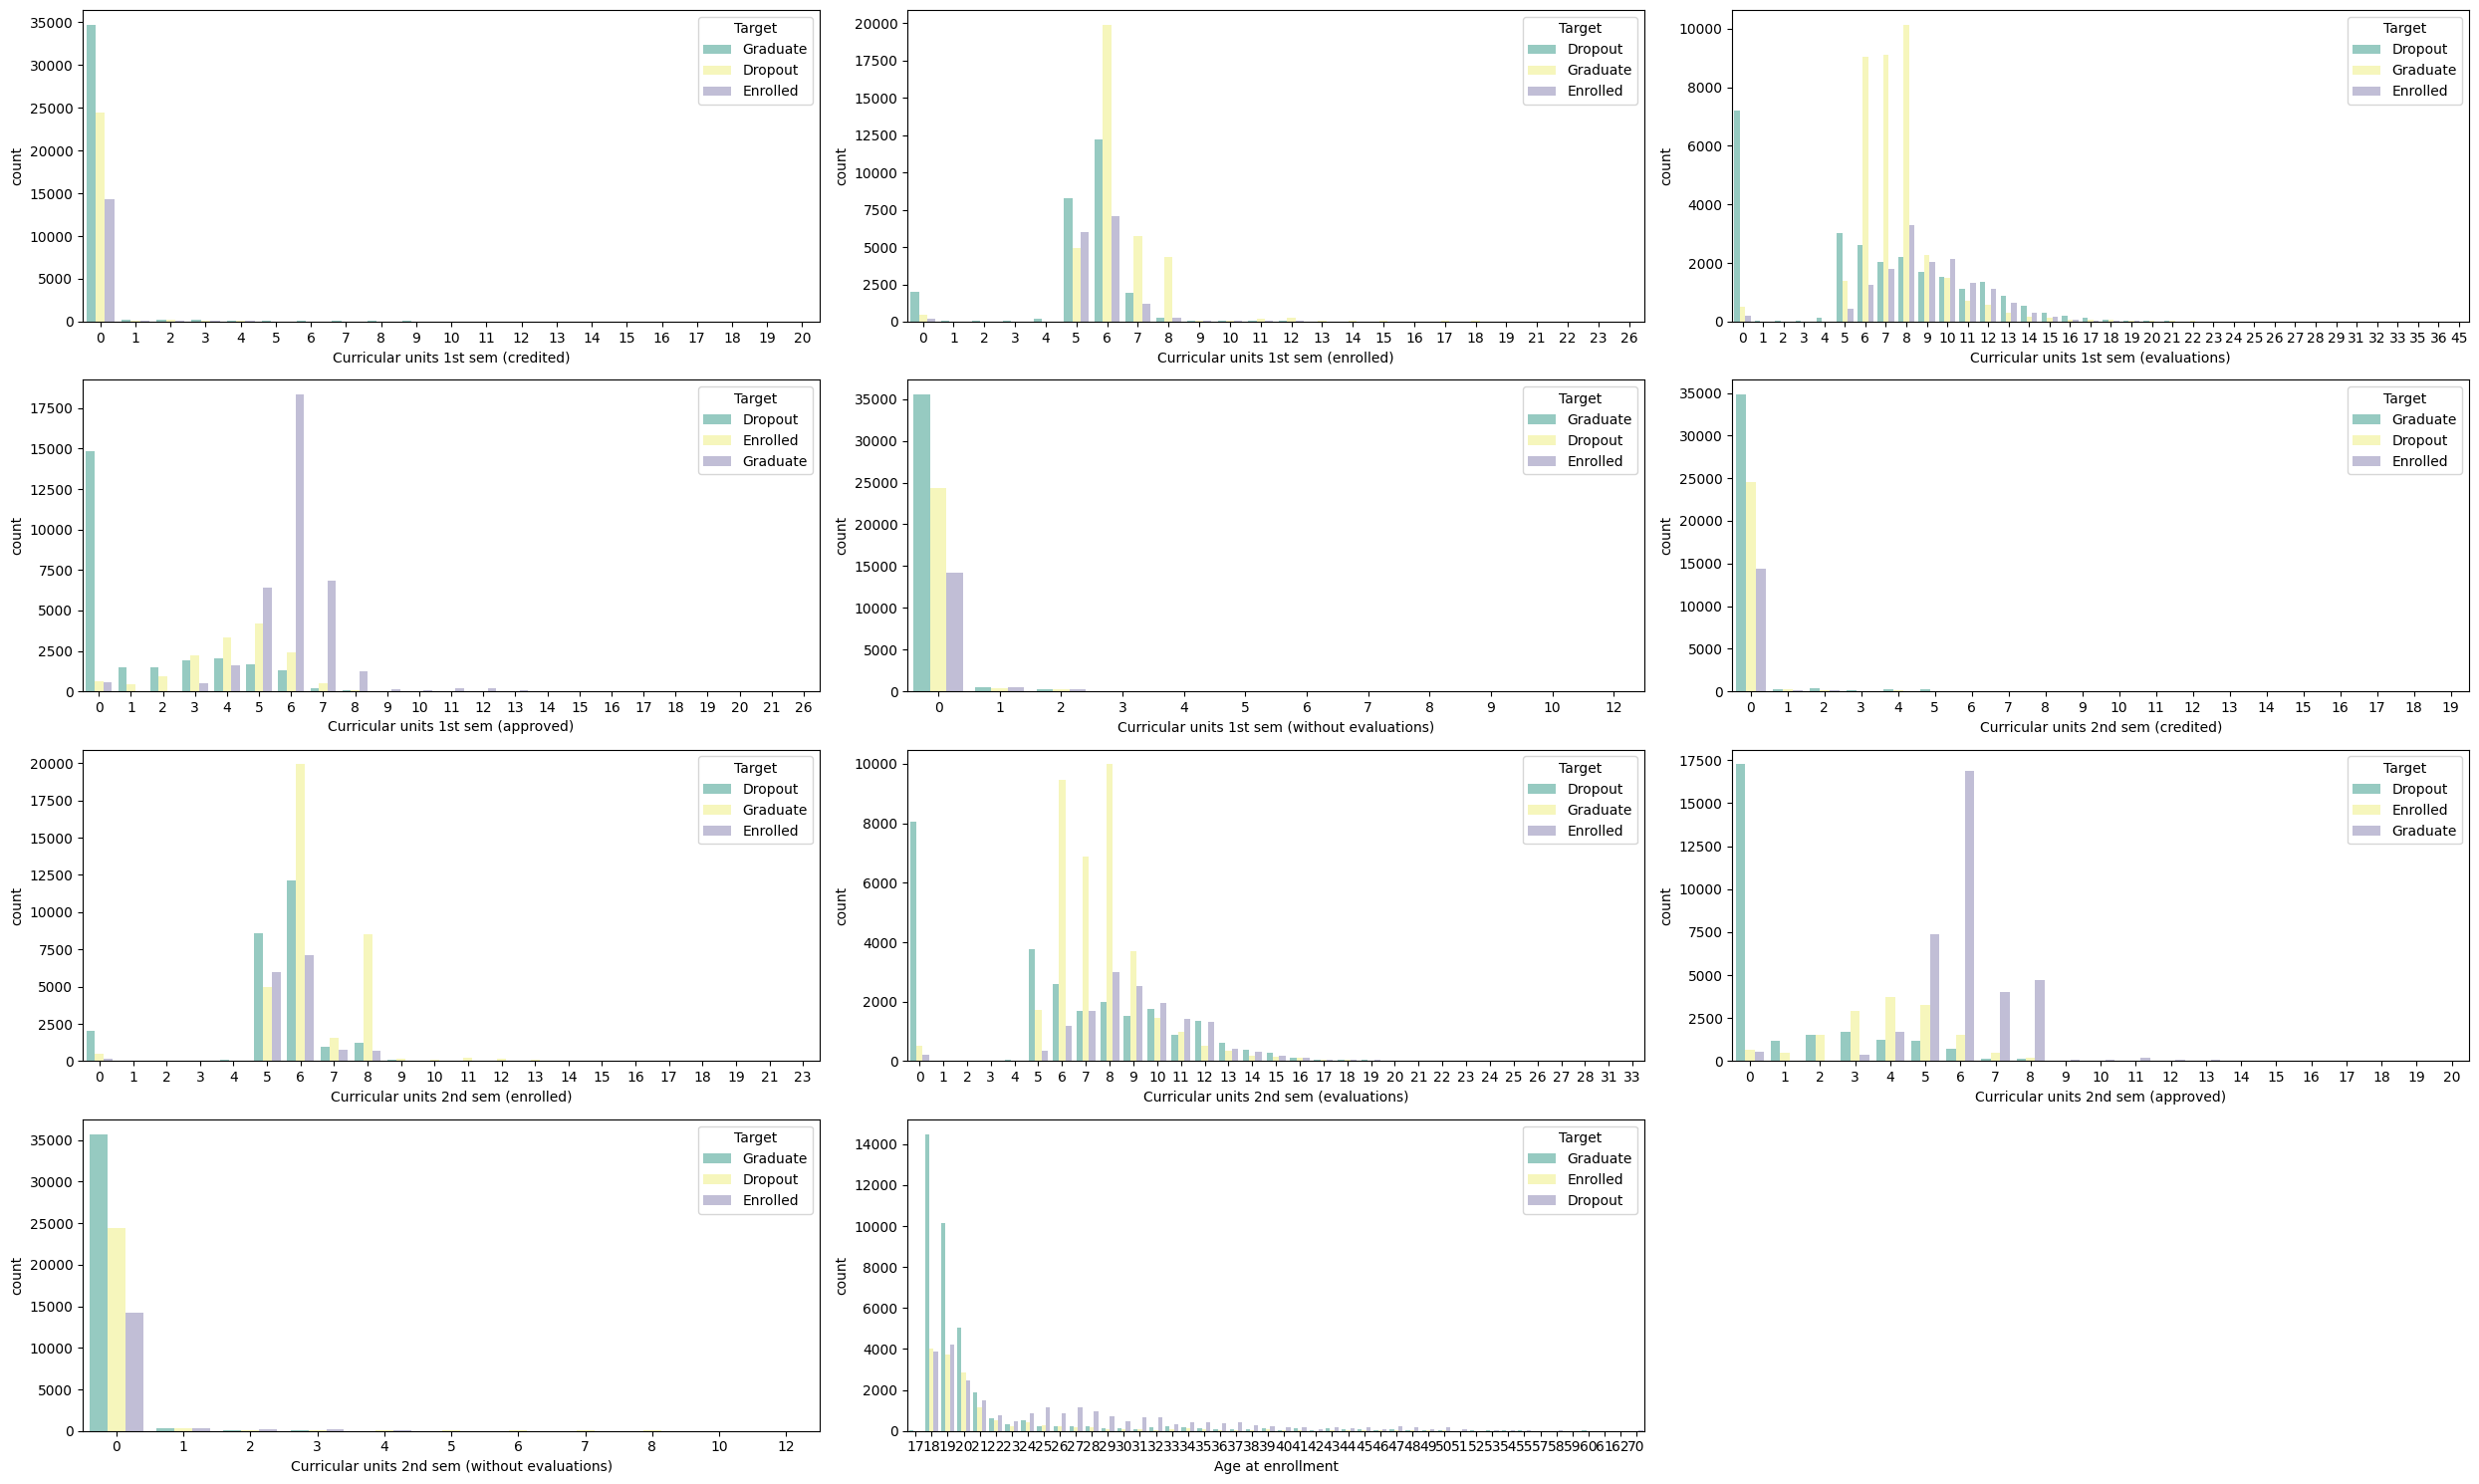

In [13]:
plt.figure(figsize=(25, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(4, 3, i+1)
    sns.countplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

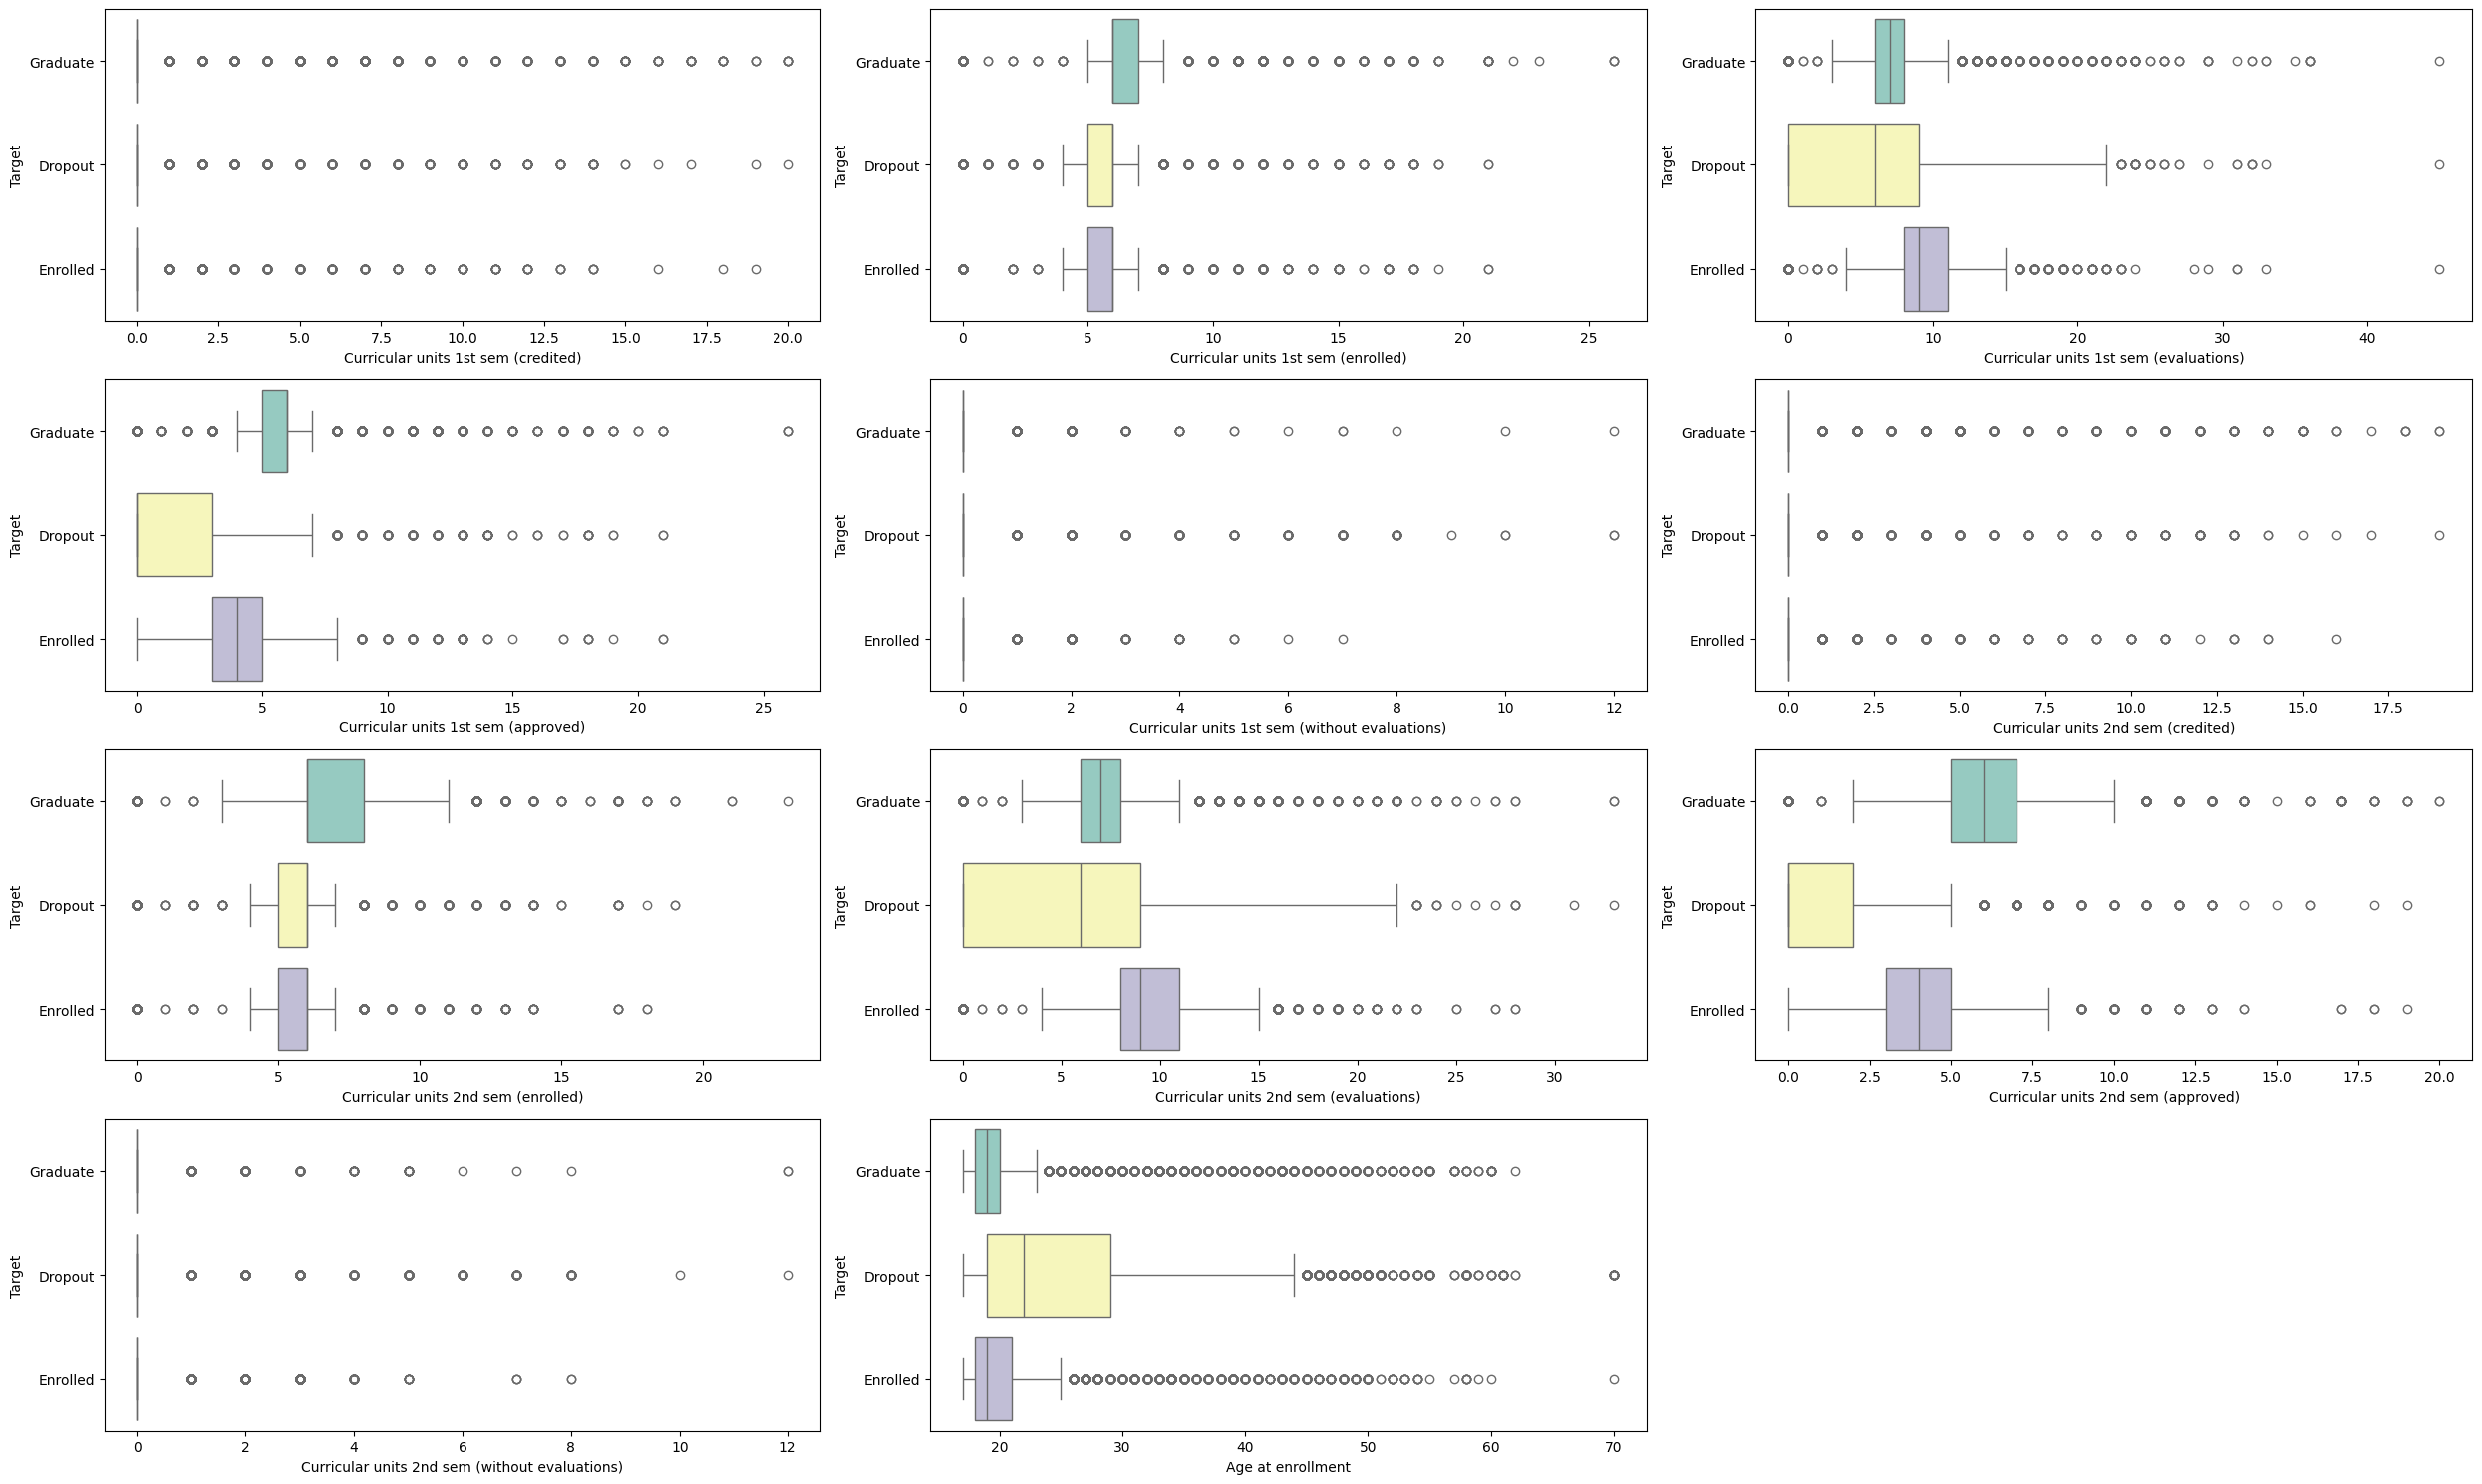

In [14]:
plt.figure(figsize=(25, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(data=train, x=col, y=target, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

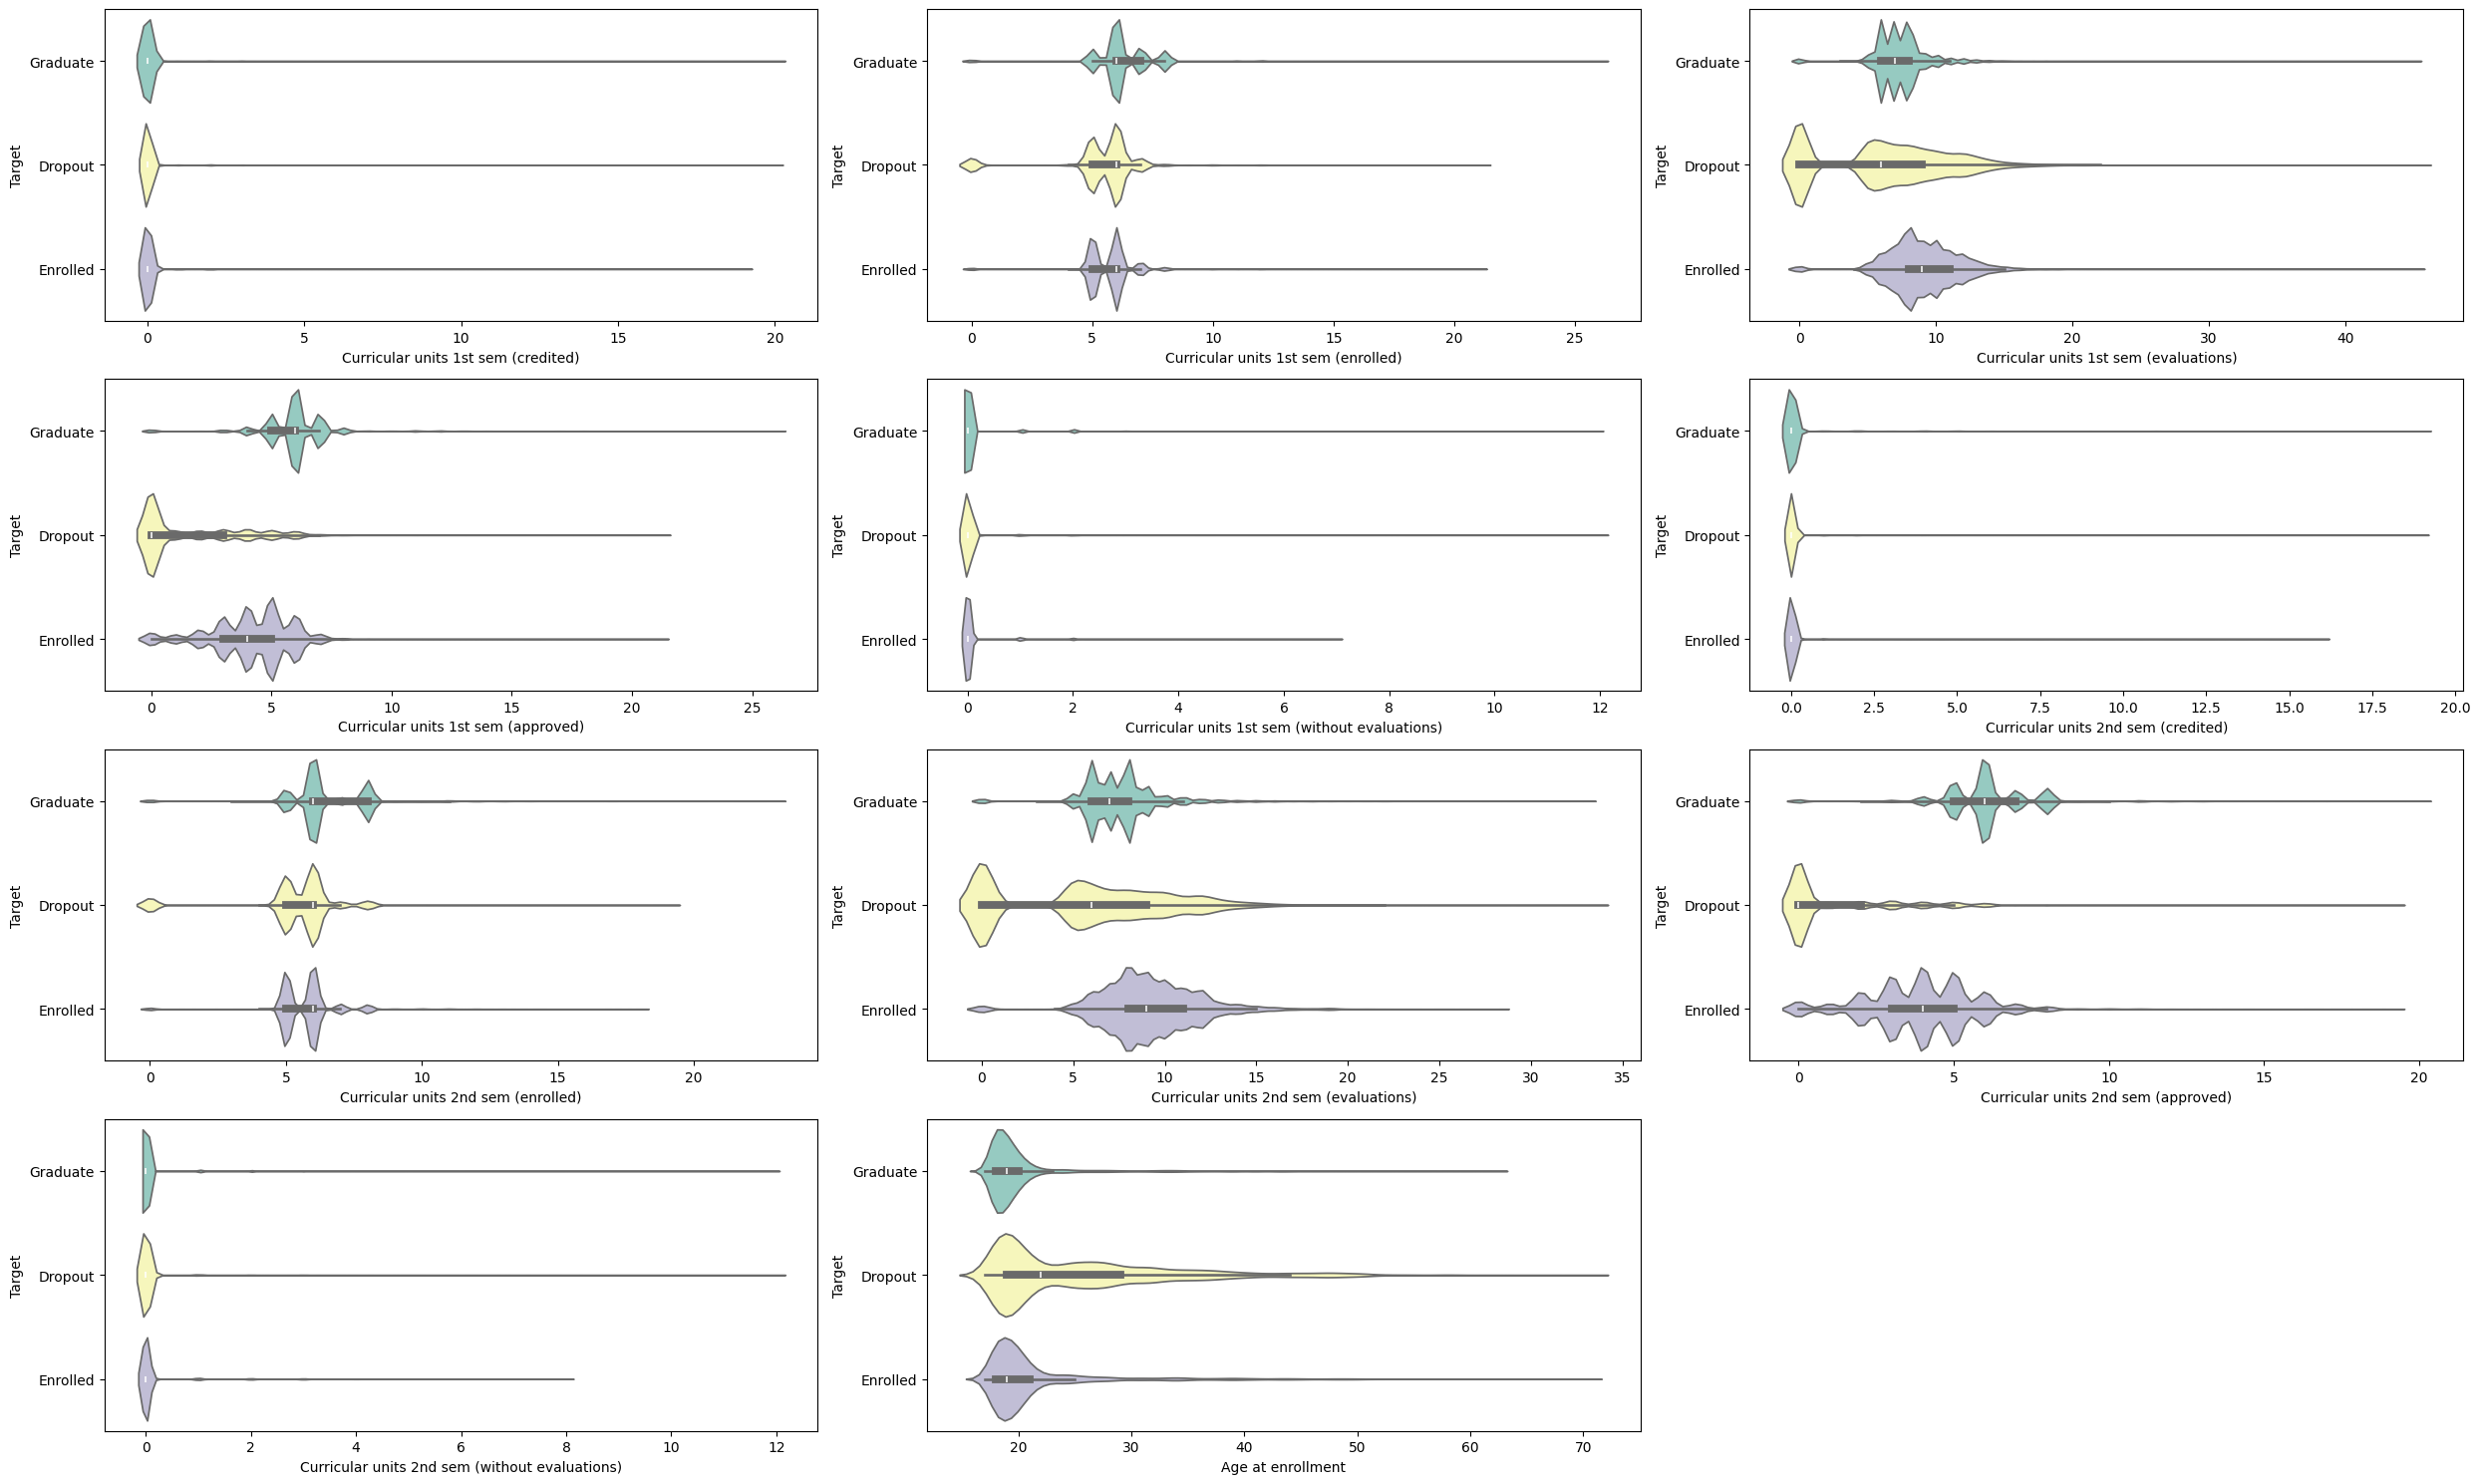

In [15]:
plt.figure(figsize=(25, 15))
for i, col in enumerate(discrete_features):
    plt.subplot(4, 3, i+1)
    sns.violinplot(data=train, x=col, y=target, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

### Распределение числовых признаков

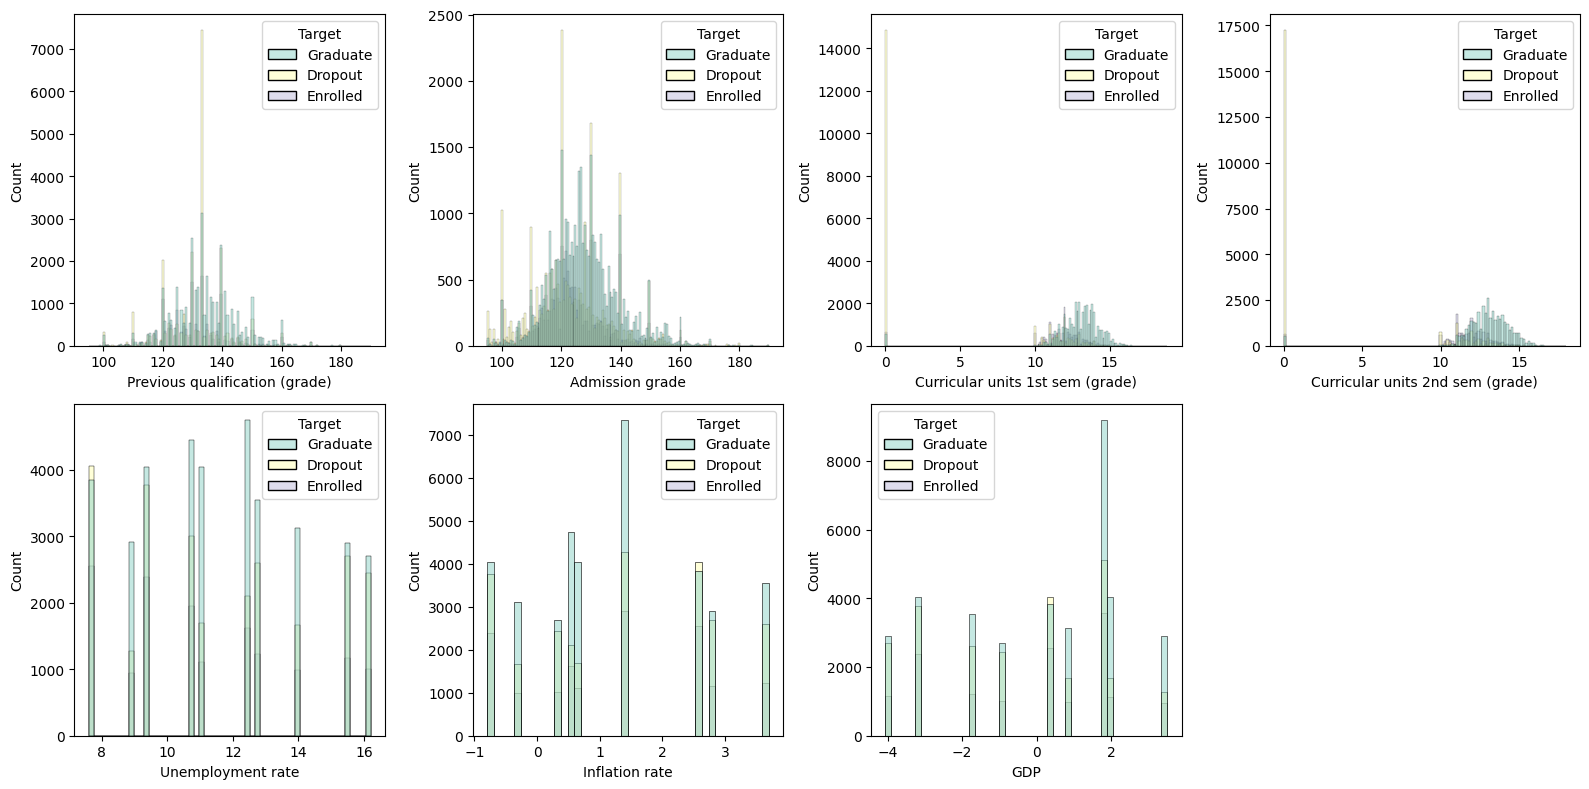

In [16]:
plt.figure(figsize=(16, 8))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

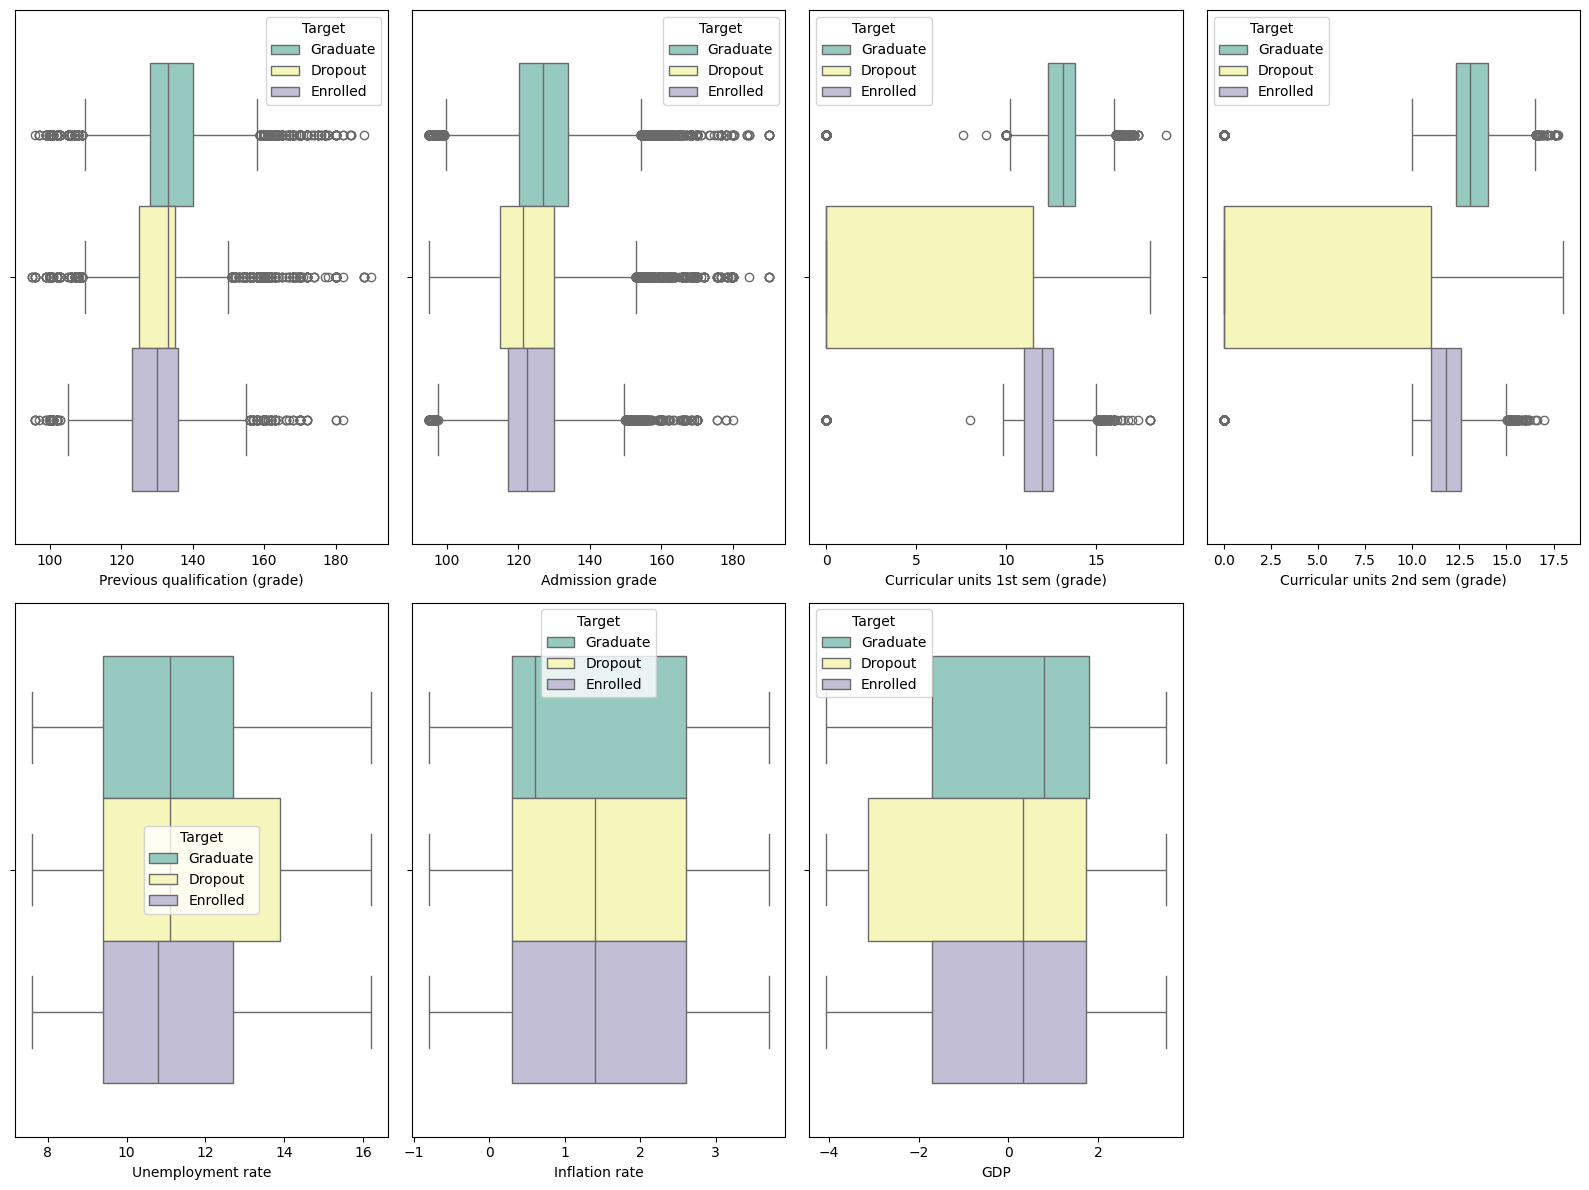

In [17]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 4, i+1)
    sns.boxplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

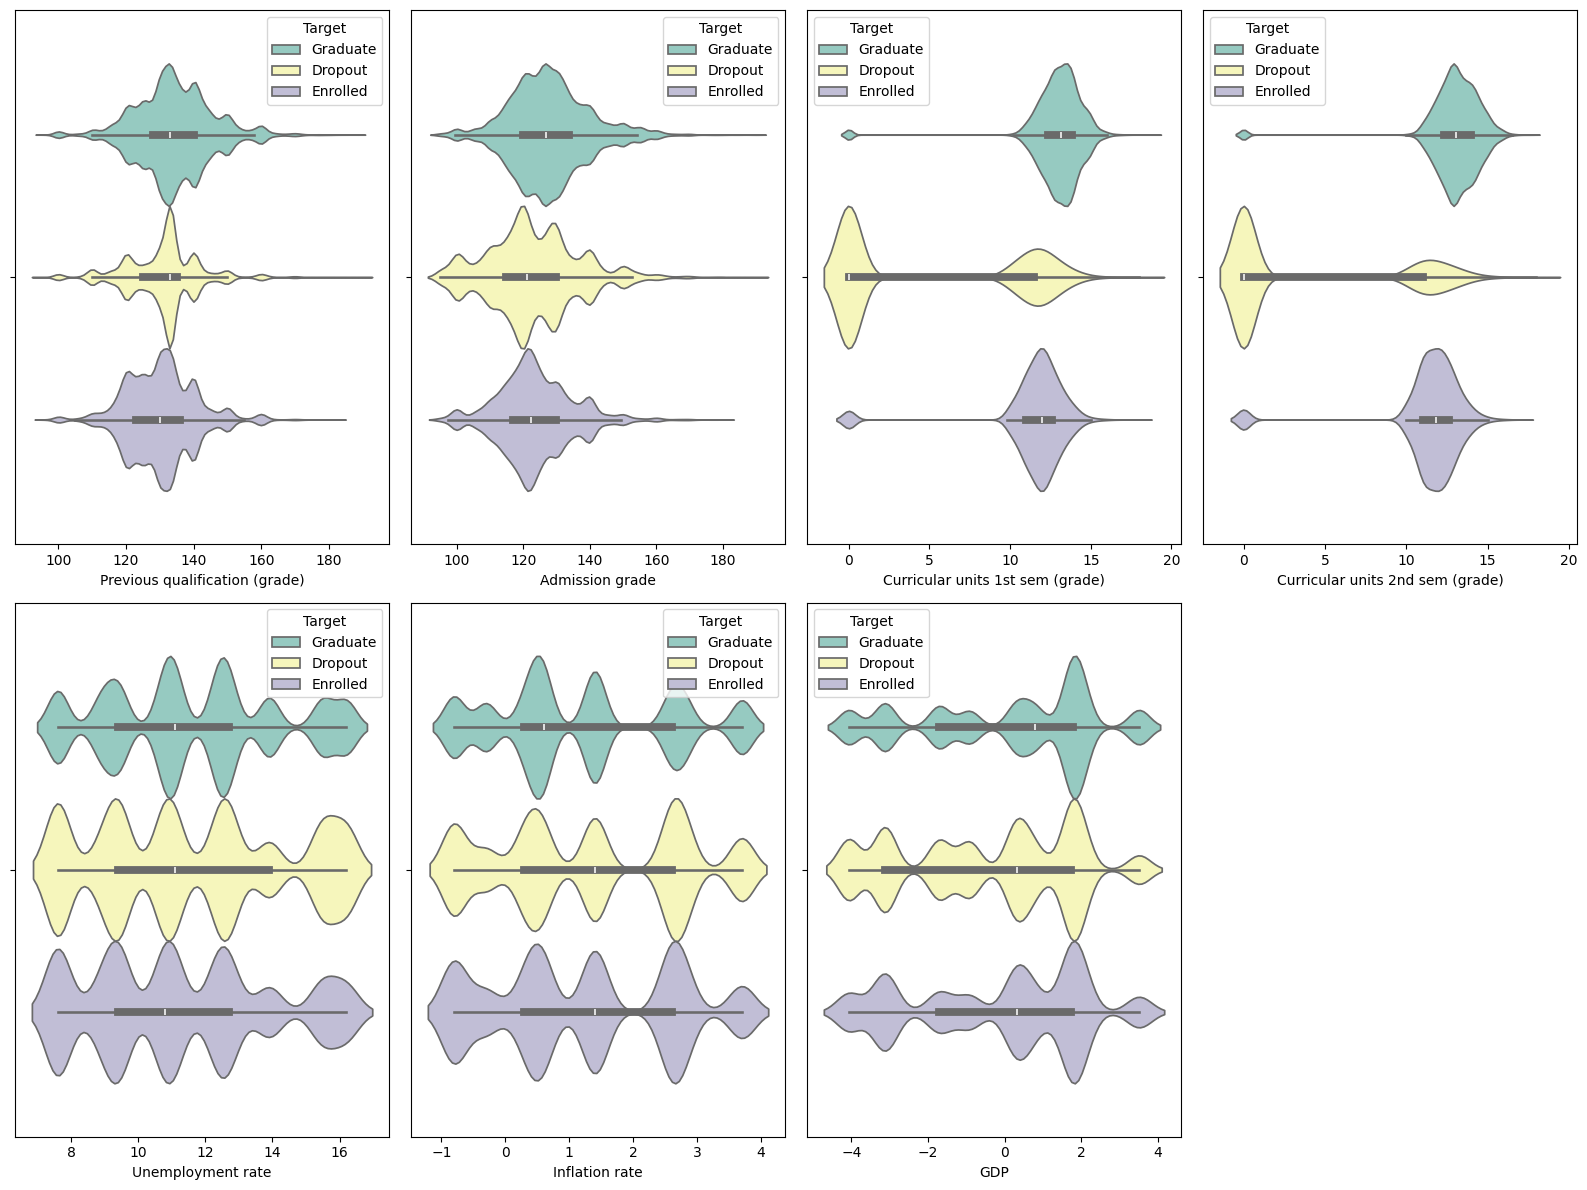

In [18]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 4, i+1)
    sns.violinplot(data=train, x=col, hue=target, palette="Set3")
plt.tight_layout()
plt.show()

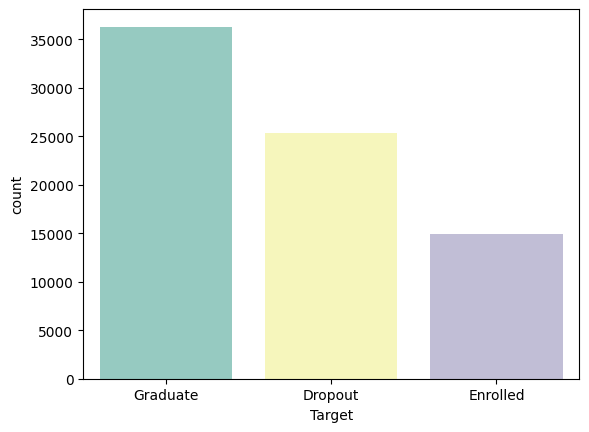

In [19]:
sns.countplot(data=train, x=target, hue=target, palette="Set3")
plt.show()

## Корреляция

interval columns not set, guessing: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation r

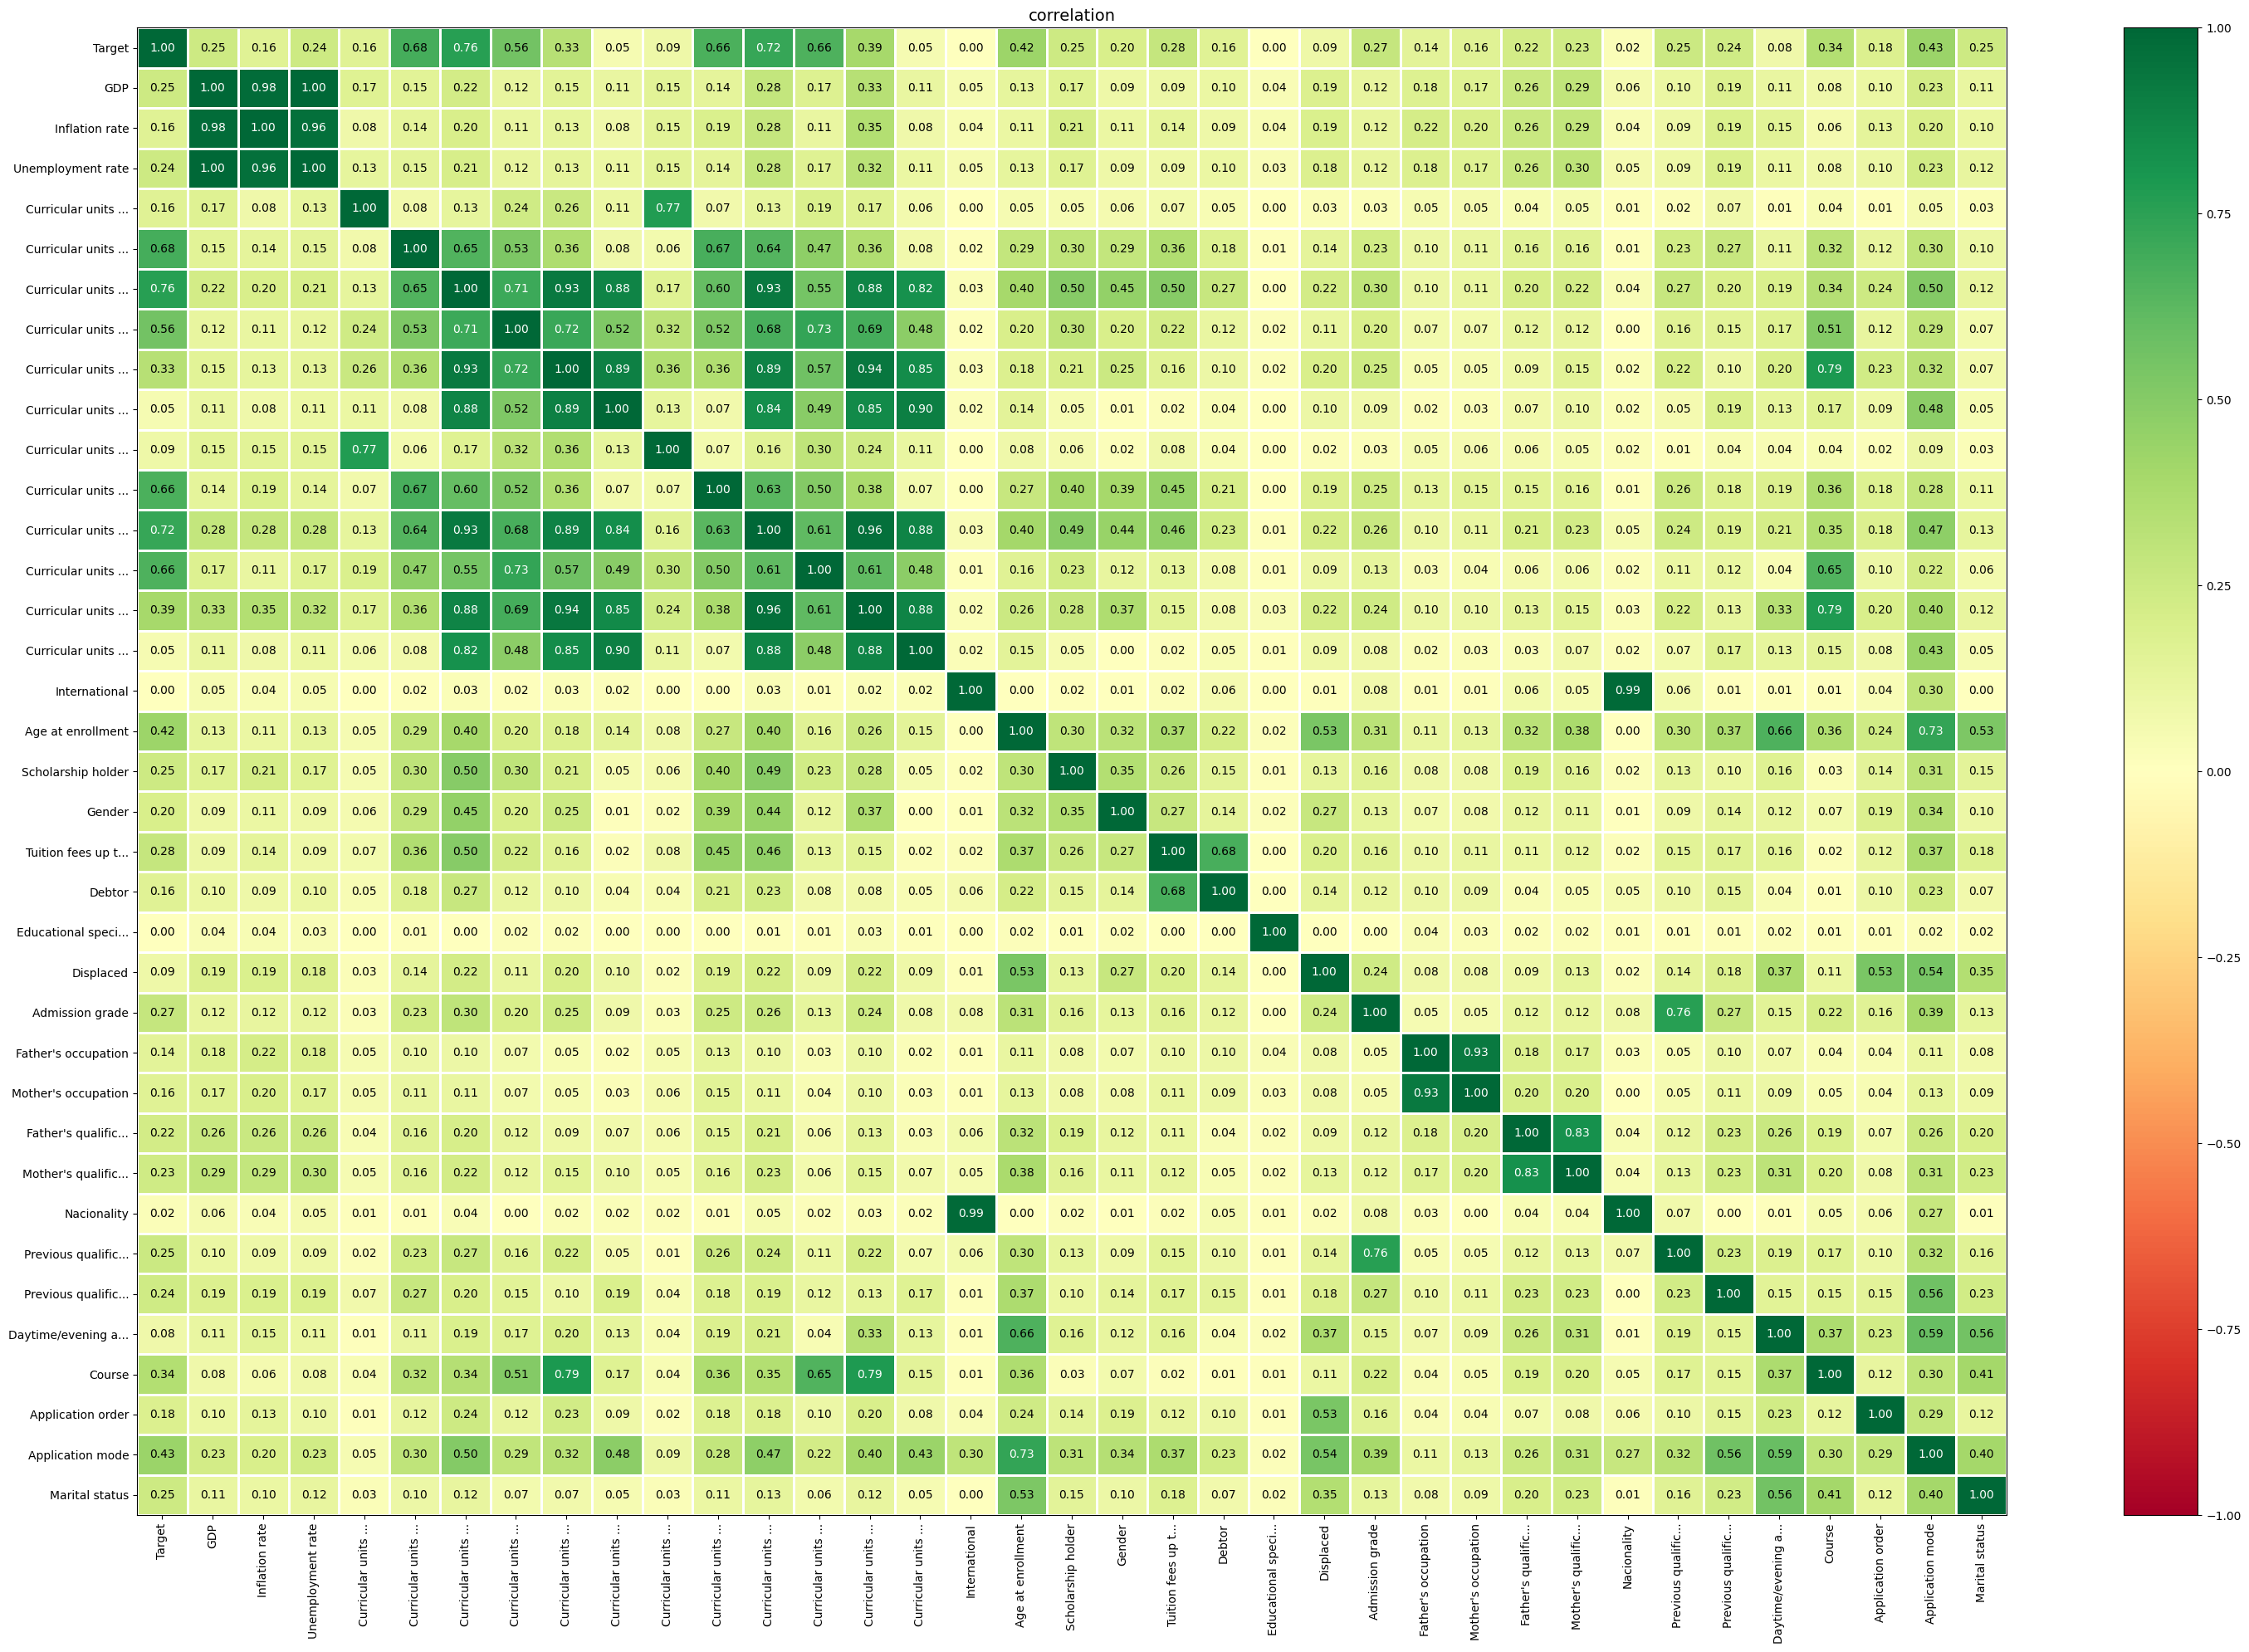

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train['Target'] = label_encoder.fit_transform(train['Target'])


corr_matrix = train.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(30,20))

### Выводы:
- Наблюдается дисбаланс целевых классов
- Данные структурно неоднородны. В каждом целевом классе наблюдается высокая вариативность.
- Ряд признаков имеет сильную правостороннюю асимметрию по большинству показателей.
- Категориальные признаки зачастую несбалансированны.


Feature engineering
- Между nacionality(национальность) и international(является ли иностранным студентом) сильная корреляция. Можно дропнуть nacionality и оставить только признак international.
- Между Unemployment rate(Уровень безработицы), Inflation rate(Уровень инфляции), GDP(Валовой внутренний продукт) сильная корреляция. Можно оставить один признак из них(unemployment rate больше всего коррелирует с target)
- Curricular units 1st sem(*) - эти признаки мультиколлениарны. Можно добавить новый признак, который будет расчитываться на их основе.

# Encoding Categorical Feature

In [21]:
sp_cols = [
    "Application mode",
    "Course",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]

lab_encoder = LabelEncoder()
for col in sp_cols:
    lab_encoder.fit(np.unique(np.concatenate([train[col], test[col]])))
    train[col] = lab_encoder.transform(train[col])
    test[col] = lab_encoder.transform(test[col])

# Baseline model

In [66]:
X = train.drop(target, axis=1).copy()
y = train[target].copy()

In [68]:
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def model_scorer(model, X, y):
    scores = cross_val_score(model, X, y, cv=skfold, scoring="f1_macro")
    return scores.mean()

In [69]:
lr = LogisticRegression(random_state=42, max_iter=100000)
lr_pipe = make_pipeline(StandardScaler(), lr)

model_scorer(lr_pipe, X, y)

np.float64(0.7714324068549784)

In [70]:
y_pred = cross_val_predict(lr, X, y, cv=skfold, n_jobs=-1)
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     25296
           1       0.62      0.55      0.58     14940
           2       0.83      0.92      0.88     36282

    accuracy                           0.82     76518
   macro avg       0.78      0.76      0.77     76518
weighted avg       0.81      0.82      0.81     76518



Text(50.722222222222214, 0.5, 'Истинные метки')

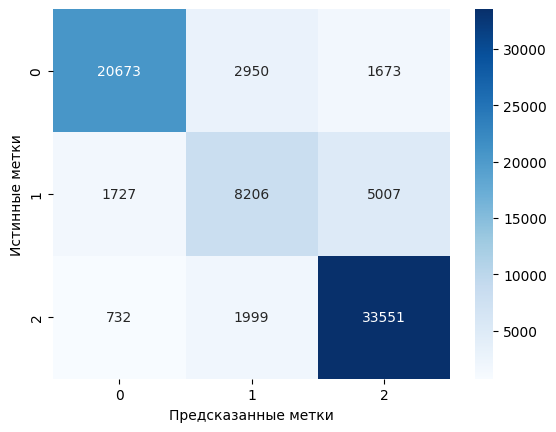

In [73]:
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')

# Модель логистической регрессии с регуляризацией

In [76]:
rlr_pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=10000))

param_grid = [
    {
        'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
        'logisticregression__penalty': ['l1'],
        'logisticregression__solver': ['saga']
    },
    {
        'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
        'logisticregression__penalty': ['l2'],
        'logisticregression__solver': ['saga']
    },
    {
        'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
        'logisticregression__penalty': ['elasticnet'],
        'logisticregression__solver': ['saga'],
        'logisticregression__l1_ratio': [0.1, 0.5, 0.9]
    }
]

grid_search = GridSearchCV(
    estimator=rlr_pipe,
    param_grid=param_grid,
    cv=skfold,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

scores = cross_val_score(grid_search, X, y, cv=skfold, scoring="f1_macro")
scores.mean()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits
Fitting 3 folds for each of 25 candidates, totalling 75 fits


np.float64(0.7709008147316183)

In [ ]:
y_pred = cross_val_predict(grid_search.best_estimator_, X, y, cv=skfold, n_jobs=-1)
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     25296
           1       0.62      0.55      0.58     14940
           2       0.83      0.92      0.88     36282

    accuracy                           0.82     76518
   macro avg       0.78      0.76      0.77     76518
weighted avg       0.81      0.82      0.81     76518



Text(50.722222222222214, 0.5, 'Истинные метки')

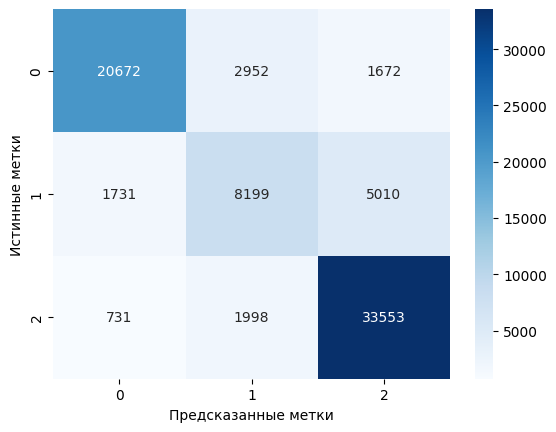

In [79]:
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')